# Integration and joint analysis of Xenium and Visium data

Authors: Elyas Heidari, Luca Marconato

## Setup
### Import libraries

In [1]:
import os
from shapely.geometry import Polygon

os.environ["USE_PYGEOS"] = "0"
import geopandas
import shutil
import numpy as np
import napari
import os
import squidpy as sq
import scanpy as sc
import pandas as pd
import anndata
import spatialdata as sd
from spatialdata.transformations import (
    Affine,
    Sequence,
    Identity,
    align_elements_using_landmarks,
    get_transformation,
    set_transformation,
)
from napari_spatialdata import Interactive
from scipy import sparse

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data paths

#### Setting up the root data folders

In [2]:
print("current working directory:", os.getcwd())
SPATIALDATA_SANDBOX_PATH = "spatialdata-sandbox"
assert os.path.isdir(
    SPATIALDATA_SANDBOX_PATH
), f"{SPATIALDATA_SANDBOX_PATH} not found, please use symlinks to make it available"
GENERATED_DATA_PATH = os.path.join(
    SPATIALDATA_SANDBOX_PATH, "generated_data/xenium_visium_integration"
)
os.makedirs(GENERATED_DATA_PATH, exist_ok=True)

current working directory: /Users/macbook/embl/projects/basel/spatialdata-notebooks/notebooks/analyses


#### Data to be downloaded

scRNA-Seq reference atlas from (TODO: @Elyas cite study), [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/generated_data/xenium_visium_integration/BC_atlas_xe.h5ad).

In [3]:
BC_SC_ATLAS_PATH = os.path.join(GENERATED_DATA_PATH, "BC_atlas_xe.h5ad")

Clonal information derived from the Visium data, [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/generated_data/xenium_visium_integration/visium_copyKat.h5ad).

In [4]:
VISIUM_CLONAL_PATH = os.path.join(GENERATED_DATA_PATH, "visium_copyKat.h5ad")

Zarr file with annotated landmark locations and a ROI polygon, drawn with napari-spatialdata and saved into a SpatialData object, [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/generated_data/xenium_visium_integration/sandbox.zarr.zip).

In [5]:
LANDMARKS_SDATA_PATH = os.path.join(GENERATED_DATA_PATH, "sandbox.zarr")

#### Data converted to Zarr with scripts from `spatialdata-sandbox` (can also be downloaded)

To get this data:
1. run spatialdata-sandbox/xenium_rep1_io/download.py;
2. run spatialdata-sandbox/xenium_rep1_io/to_zarr.py to create the zarr files.
Alternatively, it [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip).

In [6]:
XE_REP1_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data.zarr")

To get this data:
1. run spatialdata-sandbox/xenium_rep2_io/download.py;
2. run spatialdata-sandbox/xenium_rep2_io/to_zarr.py to create the zarr files.
Alternatively, it [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep2_io.zip).

In [7]:
XE_REP2_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep2_io/data.zarr")

To get this data:
1. run spatialdata-sandbox/visium_associated_xenium_io/download.py
2. run spatialdata-sandbox/visium_associated_xenium_io/to_zarr.py to create the zarr files
Alternatively, it [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip).

In [8]:
VISIUM_PATH = os.path.join(
    SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data.zarr"
)

#### Checking that all the data paths are available.

In [9]:
paths = [
    BC_SC_ATLAS_PATH,
    VISIUM_CLONAL_PATH,
    XE_REP1_PATH,
    XE_REP2_PATH,
    VISIUM_PATH,
    LANDMARKS_SDATA_PATH,
]
for path in paths:
    assert os.path.exists(path), f"{path} not found"

#### Data that will be generated by this notebook

The notebook will update in-place some of the root files above, and will also create the following Zarr files

In [10]:
# this the output path for xe_rep1
XE_REP1_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep1_roi.zarr")
# this the output path for xe_rep2
XE_REP2_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep2_roi.zarr")
# this the output path for visium
VISIUM_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "visium_roi.zarr")

### Loading the data

In [11]:
bc_sc_atlas_adata = sc.read(BC_SC_ATLAS_PATH)
bc_sc_atlas_adata.obs["dataset"] = "atlas"

xe_rep1_sdata = sd.read_zarr(XE_REP1_PATH)
xe_rep1_adata = xe_rep1_sdata.table
xe_rep1_adata.obs["dataset"] = "xe_rep1"

xe_rep2_sdata = sd.read_zarr(XE_REP2_PATH)
xe_rep2_adata = xe_rep2_sdata.table
xe_rep2_adata.obs["dataset"] = "xe_rep2"

visium_sdata = sd.read_zarr(VISIUM_PATH)
visium_adata = visium_sdata.table
visium_adata.obs["dataset"] = "visium"

landmarks_sdata = sd.read_zarr(LANDMARKS_SDATA_PATH)
clonal_adata = sc.read(VISIUM_CLONAL_PATH)

INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            


/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
landmarks_sdata

SpatialData object with:
└── Shapes
      ├── 'box': GeoDataFrame shape: (1, 1) (2D shapes)
      ├── 'rois': GeoDataFrame shape: (4, 1) (2D shapes)
      ├── 'visium_lm': GeoDataFrame shape: (3, 2) (2D shapes)
      ├── 'xe_rep1_lm': GeoDataFrame shape: (3, 2) (2D shapes)
      └── 'xe_rep2_lm': GeoDataFrame shape: (3, 2) (2D shapes)
with coordinate systems:
▸ 'global', with elements:
        box (Shapes), rois (Shapes), visium_lm (Shapes), xe_rep1_lm (Shapes), xe_rep2_lm (Shapes)

### Integrating annotations

#### Transferring cell-types into Xenium

Let's transfer the cell-types information from an single-cell atlas dataset to the Xenium cells. We will cache the result.

In [13]:
%%time

CELL_TYPES_ALREADY_TRANSFERRED = True
if not CELL_TYPES_ALREADY_TRANSFERRED:
    # this code can take 10-60 min to execute
    xe_rep1_annotated = annotate_bc_xe(bc_sc_atlas_adata, xe_rep1_adata)
    xe_rep2_annotated = annotate_bc_xe(bc_sc_atlas_adata, xe_rep2_adata)
    xe_rep1_annotated.write(os.path.join(GENERATED_DATA_PATH, "xe_rep1_annotated.h5ad"))
    xe_rep2_annotated.write(os.path.join(GENERATED_DATA_PATH, "xe_rep2_annotated.h5ad"))
else:
    xe_rep1_annotated = sc.read(
        os.path.join(GENERATED_DATA_PATH, "xe_rep1_annotated.h5ad")
    )
    xe_rep2_annotated = sc.read(
        os.path.join(GENERATED_DATA_PATH, "xe_rep2_annotated.h5ad")
    )

CPU times: user 184 ms, sys: 86.9 ms, total: 270 ms
Wall time: 291 ms


In [14]:
xe_rep1_sdata.table.obs[["celltype_major", "celltype_minor"]] = xe_rep1_annotated.obs[
    ["celltype_major", "celltype_minor"]
]
xe_rep2_sdata.table.obs[["celltype_major", "celltype_minor"]] = xe_rep2_annotated.obs[
    ["celltype_major", "celltype_minor"]
]

#### Adding clonality information into Visium

In [15]:
clones = clonal_adata.obs.set_index("barcode").loc[visium_sdata.table.obs.index][
    "clone"
]

visium_sdata.table.obs["clone"] = clones

## Spatial alignment

### Alignment using 3 landmarks points

We take `xe_rep1` as the reference section and align the other two to it. The new coordinate systems is called `aligned`.

In [16]:
xenium_subset = sd.SpatialData(
    images={
        "xe_rep1": xe_rep1_sdata.images["morphology_mip"],
        "xe_rep2": xe_rep2_sdata.images["morphology_mip"],
        "visium": visium_sdata.images["CytAssist_FFPE_Human_Breast_Cancer_full_image"],
    }
)

In [17]:
# this creates the 'aligned` coordinate system, maps the moving (xenium rep 2) and reference elements (xenium rep 1) to that system
affine_rep2_to_rep1 = align_elements_using_landmarks(
    references_coords=landmarks_sdata.shapes["xe_rep1_lm"],
    moving_coords=landmarks_sdata.shapes["xe_rep2_lm"],
    reference_element=xenium_subset.images["xe_rep1"],
    moving_element=xenium_subset.images["xe_rep2"],
    reference_coordinate_system="global",
    moving_coordinate_system="global",
    new_coordinate_system="aligned",
)

In [18]:
# same as above. Now the moving element is visium and the reference element is again xenium rep 1
affine_visium_to_rep1 = align_elements_using_landmarks(
    references_coords=landmarks_sdata.shapes["xe_rep1_lm"],
    moving_coords=landmarks_sdata.shapes["visium_lm"],
    reference_element=xenium_subset.images["xe_rep1"],
    moving_element=xenium_subset.images["visium"],
    reference_coordinate_system="global",
    moving_coordinate_system="global",
    new_coordinate_system="aligned",
)

For each element of xenium rep 1, xenium rep 2 and of visium, let's add a transformation to the coordinate system 'aligned'. This instruct the framework how to map each element to the 'aligned' coordinate system.

This part of the code will be simplified and become more ergonomic after the new coordinate systems refactoring.

In [19]:
# we use an identity for xenium rep 1 since we use it as a reference
from spatialdata import SpatialData
from spatialdata.transformations import BaseTransformation


def postpone_transformation(
    sdata: SpatialData,
    transformation: BaseTransformation,
    source_coordinate_system: str,
    target_coordinate_system: str,
):
    for element_type, element_name, element in sdata._gen_elements():
        old_transformations = get_transformation(element, get_all=True)
        if source_coordinate_system in old_transformations:
            old_transformation = old_transformations[source_coordinate_system]
            sequence = Sequence([old_transformation, transformation])
            set_transformation(element, sequence, target_coordinate_system)


postpone_transformation(
    sdata=xe_rep1_sdata,
    transformation=Identity(),
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)
postpone_transformation(
    sdata=xe_rep2_sdata,
    transformation=affine_rep2_to_rep1,
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)
postpone_transformation(
    sdata=visium_sdata,
    transformation=affine_visium_to_rep1,
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)

### Subsetting the objects to the common area

We now want to subset each object to the common area between the two Xenium replicates and the Visium data. Currently there is no function available in `spatialdata` to do a spatial subset by a generic polygon (it will be implemented), so for performing this opertation we will manually transform the data to the same coordinate system, and then implement here a version of the spatial subset.

#### Transforming cells and single-molecule points

We will now transform the data to the `aligned` coordinate system. Note that above we just defined transformations to this coordinate system but we didn't modified the data itself (this is an expensive operation). 

In [20]:
%%time
xe_rep1_transformed_sdata = sd.SpatialData(
    shapes=xe_rep1_sdata.shapes, points=xe_rep1_sdata.points, table=xe_rep1_sdata.table
)

xe_rep2_transformed_sdata = sd.SpatialData(
    shapes=xe_rep2_sdata.shapes, points=xe_rep2_sdata.points, table=xe_rep2_sdata.table
)

visium_transformed_sdata = sd.SpatialData(
    shapes=visium_sdata.shapes, points=visium_sdata.points, table=visium_sdata.table
)

xe_rep1_transformed_sdata = xe_rep1_transformed_sdata.transform_to_coordinate_system(
    "aligned"
)
xe_rep2_transformed_sdata = xe_rep2_transformed_sdata.transform_to_coordinate_system(
    "aligned"
)
visium_transformed_sdata = visium_transformed_sdata.transform_to_coordinate_system(
    "aligned"
)

INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
CPU times: user 32.3 s, sys: 3.55 s, total: 35.8 s
Wall time: 29.1 s


#### Getting the polygon describing the common area

In [21]:
from geopandas import GeoSeries

def get_extent(geoseries: GeoSeries):
    min_x, min_y = np.min(geoseries.bounds.iloc[:, :2], axis=0)
    max_x, max_y = np.max(geoseries.bounds.iloc[:, 2:], axis=0)
    print(f"min_x = {min_x}, min_y = {min_y}, max_x = {max_x}, max_y = {max_y}")

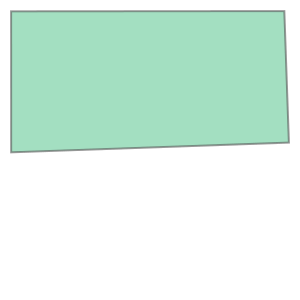

In [22]:
# we manually draw the polygon that contains the common area between the samples
box = landmarks_sdata.shapes["box"]
# let's get the Polygon object out of the GeoDataFrame
box = box.geometry.iloc[0]
box

#### Filtering the data inside the common area

Helper functions to convert back and forth between points and shapes, these functions will not be needed in a later version of `spatialdata` as we will use `geopandas` also for representing points and not just shapes.

In [23]:
from dask.dataframe.core import DataFrame as DaskDataFrame
from geopandas import GeoDataFrame


def points_dask_dataframe_to_geopandas(points: DaskDataFrame) -> GeoDataFrame:
    # let's ignore the z component here
    points_gdf = GeoDataFrame(
        geometry=geopandas.points_from_xy(points["x"], points["y"])
    )
    for c in points.columns:
        points_gdf[c] = points[c]
    return points_gdf


def points_geopandas_to_dask_dataframe(gdf: GeoDataFrame) -> DaskDataFrame:
    # convert the GeoDataFrame to a Dask DataFrame
    ddf = dd.from_pandas(gdf[gdf.columns.drop("geometry")], npartitions=1)
    ddf["x"] = gdf.geometry.x
    ddf["y"] = gdf.geometry.y
    # parse
    ddf = PointsModel.parse(ddf, coordinates={"x": "x", "y": "y"})
    return ddf

The functions below implement spatial queries operations on polygons. These functions will be implemented in SpatialData and the code will become simpler.

In [24]:
%%time
from shapely import Polygon
from spatialdata.models import ShapesModel, PointsModel
from dask.dataframe.core import DataFrame as DaskDataFrame
import dask.dataframe as dd


def spatial_query_shapes_and_points_by_polygon(
    sdata: SpatialData, polygon: Polygon, target_coordinate_system: str
):
    new_shapes = {}
    for shapes_name, shapes in sdata.shapes.items():
        if "__old_index" in shapes.columns:
            assert np.all(shapes["__old_index"] == shapes.index)
        else:
            shapes["__old_index"] = shapes.index
        # indices = shapes.intersects(polygon)
        # indices = shapes.geometry.apply(lambda x: x.intersects(polygon).values.tolist()[0][0])
        indices = shapes.geometry.apply(lambda x: x.intersects(polygon))
        if np.sum(indices) == 0:
            raise ValueError("we expect at least one shape")
        queried_shapes = shapes[indices]
        queried_shapes.index = queried_shapes["__old_index"]
        del shapes["__old_index"]
        del queried_shapes["__old_index"]
        transformation = get_transformation(shapes, target_coordinate_system)
        queried_shapes = ShapesModel.parse(queried_shapes)
        set_transformation(queried_shapes, transformation, target_coordinate_system)
        new_shapes[shapes_name] = queried_shapes

    new_points = {}
    for points_name, points in sdata.points.items():
        # let's ignore the z component here
        points_gdf = points_dask_dataframe_to_geopandas(points)
        # queried_points = points_gdf.intersects(pp)
        indices = points_gdf.geometry.intersects(polygon)
        if np.sum(indices) == 0:
            raise ValueError("we expect at least one point")
        queried_points = points_gdf[indices]
        ddf = points_geopandas_to_dask_dataframe(queried_points)
        new_points[points_name] = ddf

    return SpatialData(shapes=new_shapes, points=new_points, table=sdata.table)

CPU times: user 29 µs, sys: 28 µs, total: 57 µs
Wall time: 23.1 µs


In [25]:
%%time
# let's keep only the shapes inside the query polygon (roi)
# and then let's manually filter the table to keep only the rows that are inside the polygon pp
xe_rep1_roi_sdata = spatial_query_shapes_and_points_by_polygon(
    sdata=xe_rep1_transformed_sdata,
    polygon=box,
    target_coordinate_system="aligned",
)

CPU times: user 4min 43s, sys: 45 s, total: 5min 28s
Wall time: 4min 8s


In [26]:
merged = pd.merge(
    xe_rep1_roi_sdata.table.obs[["cell_id"]],
    xe_rep1_roi_sdata.shapes["cell_circles"],
    how="right",
    left_on="cell_id",
    right_index=True,
)
filtered_table = xe_rep1_roi_sdata.table[merged.index].copy()
del xe_rep1_roi_sdata.table
xe_rep1_roi_sdata.table = filtered_table

In [27]:
%%time
xe_rep2_roi_sdata = spatial_query_shapes_and_points_by_polygon(
    sdata=xe_rep2_transformed_sdata,
    polygon=box,
    target_coordinate_system="aligned",
)

CPU times: user 4min 42s, sys: 2min 23s, total: 7min 6s
Wall time: 4min 24s


In [28]:
merged = pd.merge(
    xe_rep2_roi_sdata.table.obs[["cell_id"]],
    xe_rep2_roi_sdata.shapes["cell_circles"],
    how="right",
    left_on="cell_id",
    right_index=True,
)
filtered_table = xe_rep2_roi_sdata.table[merged.index].copy()
del xe_rep2_roi_sdata.table
xe_rep2_roi_sdata.table = filtered_table

In [29]:
%%time
visium_roi_sdata = spatial_query_shapes_and_points_by_polygon(
    sdata=visium_transformed_sdata,
    polygon=box,
    target_coordinate_system="aligned",
)

CPU times: user 61.6 ms, sys: 2.33 ms, total: 63.9 ms
Wall time: 64.4 ms


In [30]:
merged = pd.merge(
    visium_roi_sdata.table.obs[["spot_id"]],
    visium_roi_sdata.shapes["CytAssist_FFPE_Human_Breast_Cancer"],
    how="right",
    left_on="spot_id",
    right_index=True,
)
filtered_table = visium_roi_sdata.table[
    visium_roi_sdata.shapes["CytAssist_FFPE_Human_Breast_Cancer"].index
].copy()
del visium_roi_sdata.table
visium_roi_sdata.table = filtered_table

### Subsetting the objects to the common genes

In [31]:
from copy import copy

sel_genes = list(
    set(visium_roi_sdata.table.var_names) & (set(xe_rep1_roi_sdata.table.var_names))
)

filtered_table = xe_rep1_roi_sdata.table[:, sel_genes].copy()
del xe_rep1_roi_sdata.table
xe_rep1_roi_sdata.table = filtered_table

filtered_table = xe_rep2_roi_sdata.table[:, sel_genes].copy()
del xe_rep2_roi_sdata.table
xe_rep2_roi_sdata.table = filtered_table

filtered_table = visium_roi_sdata.table[:, sel_genes].copy()
del visium_roi_sdata.table
visium_roi_sdata.table = filtered_table

## Aggregation of cell-types and gene expression from the Xenium cells into the Visium circles

We will now aggregate the cell-type information and the gene expression into the Visium circles. These aggregation functionalities are not yet available in `spatialdata` so we implement them here. The corresponding code will be moved inside the `spatialdata` package.

In [32]:
%%time
visium_spots_polygons = visium_roi_sdata.shapes[
    "CytAssist_FFPE_Human_Breast_Cancer"
].copy()
visium_spots_polygons["geometry"] = visium_spots_polygons.buffer(
    visium_spots_polygons.radius.iloc[0], 128
)
visium_spots_polygons["spot_id"] = visium_spots_polygons.index
xe_rep1_roi_sdata.shapes["cell_boundaries"]["cell_id"] = xe_rep1_roi_sdata.shapes[
    "cell_boundaries"
].index
xe_rep2_roi_sdata.shapes["cell_boundaries"]["cell_id"] = xe_rep2_roi_sdata.shapes[
    "cell_boundaries"
].index

spots_xe_rep1 = visium_spots_polygons.overlay(
    xe_rep1_roi_sdata.shapes["cell_boundaries"], how="intersection"
)
spots_xe_rep2 = visium_spots_polygons.overlay(
    xe_rep2_roi_sdata.shapes["cell_boundaries"], how="intersection"
)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


CPU times: user 11.5 s, sys: 195 ms, total: 11.7 s
Wall time: 11.8 s


Each Visium circle is deconvolved based on the intersected areas with the xenium cells. We do this for both repolicates and at the minor and major cell type levels.

### Xenium replicate 1

In [33]:
from sklearn.preprocessing import OneHotEncoder

spots_xe_rep1["area"] = spots_xe_rep1["geometry"].area
ss = spots_xe_rep1.pivot_table(
    index=["spot_id"], columns="cell_id", values="area", aggfunc="sum"  # add margins
).fillna(0)
ss_raw = ss.copy()
ss = ss.div(ss.sum(axis=1), axis=0)

missing_spots = list(set(visium_spots_polygons["spot_id"]).difference(set(ss.index)))
ms_df = pd.DataFrame([[0] * ss.shape[1]], columns=ss.columns, index=missing_spots)

ss = ss.append(ms_df)
ss = ss.loc[visium_roi_sdata.table.obs["spot_id"]]

ss_raw = ss_raw.append(ms_df)
ss_raw = ss_raw.loc[visium_roi_sdata.table.obs["spot_id"]]

/tmp/ipykernel_34914/772322310.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss = ss.append(ms_df)
/tmp/ipykernel_34914/772322310.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss_raw = ss_raw.append(ms_df)


In [34]:
area_cells = xe_rep1_roi_sdata.shapes["cell_boundaries"][
    xe_rep1_roi_sdata.shapes["cell_boundaries"].index.isin(ss_raw.columns.tolist())
].geometry.area

A = ss_raw.div(area_cells, axis=1)
B = xe_rep1_sdata.table[xe_rep1_sdata.table.obs.cell_id.isin(ss.columns.tolist())]

sparse_A = sparse.csr_matrix(A)
C = sparse_A @ B.X
# gene expression interpolating Xenium cells gene expression into Visium circles
visium_gene_expression_from_xenium_cells_rep1 = anndata.AnnData(
    C.toarray(), var=xe_rep1_sdata.table.var
)

/tmp/ipykernel_34914/1569935777.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  visium_gene_expression_from_xenium_cells_rep1 = anndata.AnnData(


In [35]:
ohe = OneHotEncoder()
major_one = ohe.fit_transform(
    xe_rep1_sdata.table[list(ss.columns), :].obs[["celltype_major"]]
)
spot_xe_rep1_types = ss.to_numpy() @ major_one
visium_roi_sdata.table.copy().obsm["xe_rep1_celltype_major"] = spot_xe_rep1_types

ohe = OneHotEncoder()
minor_one = ohe.fit_transform(
    xe_rep1_sdata.table[list(ss.columns), :].obs[["celltype_minor"]]
)
spot_xe_rep1_types = ss.to_numpy() @ minor_one
visium_roi_sdata.table.obsm["xe_rep1_celltype_minor"] = spot_xe_rep1_types

In [36]:
visium_roi_sdata.table.layers[
    "xe_rep1_cells"
] = visium_gene_expression_from_xenium_cells_rep1[:, sel_genes].X.copy()

### Xenium replicate 2

In [37]:
spots_xe_rep2["area"] = spots_xe_rep2["geometry"].area
ss = spots_xe_rep2.pivot_table(
    index=["spot_id"], columns="cell_id", values="area", aggfunc="sum"  # add margins
).fillna(0)
ss_raw = ss.copy()
ss = ss.div(ss.sum(axis=1), axis=0)

missing_spots = list(set(visium_spots_polygons["spot_id"]).difference(set(ss.index)))
ms_df = pd.DataFrame([[0] * ss.shape[1]], columns=ss.columns, index=missing_spots)

ss = ss.append(ms_df)
ss = ss.loc[visium_roi_sdata.table.obs["spot_id"]]

ss_raw = ss_raw.append(ms_df)
ss_raw = ss_raw.loc[visium_roi_sdata.table.obs["spot_id"]]

/tmp/ipykernel_34914/4027164512.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss = ss.append(ms_df)
/tmp/ipykernel_34914/4027164512.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss_raw = ss_raw.append(ms_df)


In [38]:
area_cells = xe_rep2_roi_sdata.shapes["cell_boundaries"][
    xe_rep2_roi_sdata.shapes["cell_boundaries"].index.isin(ss_raw.columns.tolist())
].geometry.area

A = ss_raw.div(area_cells, axis=1)
B = xe_rep2_sdata.table[xe_rep2_sdata.table.obs.cell_id.isin(ss.columns.tolist())]

sparse_A = sparse.csr_matrix(A)
C = sparse_A @ B.X
# gene expression interpolating Xenium cells gene expression into Visium circles
visium_gene_expression_from_xenium_cells_rep2 = anndata.AnnData(
    C.toarray(), var=xe_rep2_sdata.table.var
)

/tmp/ipykernel_34914/2847905008.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  visium_gene_expression_from_xenium_cells_rep2 = anndata.AnnData(


In [39]:
ohe = OneHotEncoder()
major_one = ohe.fit_transform(
    xe_rep2_sdata.table[list(ss.columns), :].obs[["celltype_major"]]
)
spot_xe_rep2_types = ss.to_numpy() @ major_one
visium_roi_sdata.table.obsm["xe_rep2_celltype_major"] = spot_xe_rep2_types

ohe = OneHotEncoder()
minor_one = ohe.fit_transform(
    xe_rep2_sdata.table[list(ss.columns), :].obs[["celltype_minor"]]
)
spot_xe_rep2_types = ss.to_numpy() @ minor_one
visium_roi_sdata.table.obsm["xe_rep2_celltype_minor"] = spot_xe_rep2_types

In [40]:
visium_roi_sdata.table.layers[
    "xe_rep2_cells"
] = visium_gene_expression_from_xenium_cells_rep2[:, sel_genes].X.copy()

## Aggregation of gene expression from the Xenium single-molecule points into the Visium Circles

In [41]:
%%time
xe_rep1_tx_roi = points_dask_dataframe_to_geopandas(
    xe_rep1_roi_sdata.points["transcripts"]
)
xe_rep2_tx_roi = points_dask_dataframe_to_geopandas(
    xe_rep2_roi_sdata.points["transcripts"]
)

CPU times: user 55.9 s, sys: 50.9 s, total: 1min 46s
Wall time: 1min 58s


In [42]:
%%time
spots_xe_rep1_tx = xe_rep1_tx_roi.overlay(visium_spots_polygons, how="intersection")

CPU times: user 5min 41s, sys: 25 s, total: 6min 6s
Wall time: 6min 15s


In [43]:
%%time
spots_xe_rep2_tx = xe_rep2_tx_roi.overlay(visium_spots_polygons, how="intersection")

CPU times: user 5min 30s, sys: 24.8 s, total: 5min 55s
Wall time: 6min 4s


In [44]:
# TODO fix bug with feature_name: https://github.com/scverse/spatialdata-io/issues/25
spots_xe_rep1_tx["feature_name"] = [
    gene[2:-1] for gene in spots_xe_rep1_tx["feature_name"]
]
spots_xe_rep2_tx["feature_name"] = [
    gene[2:-1] for gene in spots_xe_rep2_tx["feature_name"]
]

Note that for some Visium circles we don't have any transcript inside, so we need to manually ad those Visium circles (and re-sort the indices to match the original ordering).

In [45]:
spots_xe_rep1_counts = spots_xe_rep1_tx.pivot_table(
    index=["spot_id"],
    columns="feature_name",
    values="radius",  # add margins
    aggfunc="sum",
).fillna(0)
missing_spots = list(
    set(visium_spots_polygons["spot_id"]).difference(set(spots_xe_rep1_counts.index))
)
ms_df = pd.DataFrame(
    [[0] * spots_xe_rep1_counts.shape[1]],
    columns=spots_xe_rep1_counts.columns,
    index=missing_spots,
)
spots_xe_rep1_counts = spots_xe_rep1_counts.append(ms_df)
spots_xe_rep1_counts = spots_xe_rep1_counts.loc[visium_roi_sdata.table.obs["spot_id"]]
spots_xe_rep1_counts = spots_xe_rep1_counts[sel_genes].to_numpy()
visium_roi_sdata.table.layers["xe_rep1_tx"] = spots_xe_rep1_counts

/tmp/ipykernel_34914/3190220434.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spots_xe_rep1_counts = spots_xe_rep1_counts.append(ms_df)


In [46]:
spots_xe_rep2_counts = spots_xe_rep2_tx.pivot_table(
    index=["spot_id"],
    columns="feature_name",
    values="radius",  # add margins
    aggfunc="sum",
).fillna(0)
missing_spots = list(
    set(visium_spots_polygons["spot_id"]).difference(set(spots_xe_rep2_counts.index))
)
ms_df = pd.DataFrame(
    [[0] * spots_xe_rep2_counts.shape[1]],
    columns=spots_xe_rep2_counts.columns,
    index=missing_spots,
)
spots_xe_rep2_counts = spots_xe_rep2_counts.append(ms_df)
spots_xe_rep2_counts = spots_xe_rep2_counts.loc[visium_roi_sdata.table.obs["spot_id"]]
spots_xe_rep2_counts = spots_xe_rep2_counts[sel_genes].to_numpy()
visium_roi_sdata.table.layers["xe_rep2_tx"] = spots_xe_rep2_counts

/tmp/ipykernel_34914/503191660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spots_xe_rep2_counts = spots_xe_rep2_counts.append(ms_df)


## Saving the data

In [47]:
xe_rep1_roi_sdata

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (100849, 2) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (100444, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (100646, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 100444 × 307
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': AnnData (100444, 307)
with coordinate systems:
▸ 'aligned', with elements:
        cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)
▸ 'global', with elements:
        transcripts (Points)

In [48]:
xe_rep2_roi_sdata

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (99923, 2) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (99635, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (99761, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 99635 × 307
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': AnnData (99635, 307)
with coordinate systems:
▸ 'aligned', with elements:
        cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)
▸ 'global', with elements:
        transcripts (Points)

In [49]:
visium_roi_sdata

SpatialData object with:
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (2775, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 2775 × 307
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'clone_colors', 'region_colors', 'spatial', 'spatialdata_attrs'
    obsm: 'spatial', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_cells', 'xe_rep2_cells', 'xe_rep1_tx', 'xe_rep2_tx': AnnData (2775, 307)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer (Shapes)

In [50]:
# save transformations to disk (it was only in-memory so far)
# TODO: we have to make this more ergonomic and transparent (in the spatiadata package)

def save_all_transformations(sdata: SpatialData) -> None:
    for element in sdata._gen_elements_values():
        transformations = get_transformation(element, get_all=True)
        set_transformation(element, transformations, set_all=True, write_to_sdata=sdata)


save_all_transformations(xe_rep1_sdata)
save_all_transformations(xe_rep2_sdata)
save_all_transformations(visium_sdata)

In [51]:
# the table of the xenium data was modified only in-memory, let's sync the change to disk
# TODO: also this needs to be improved

def save_table(sdata: SpatialData) -> None:
    table = sdata.table
    del sdata.table
    # this is triggering the writing to disk, it is not intuitive
    sdata.table = table


save_table(xe_rep1_sdata)
save_table(xe_rep2_sdata)
save_table(visium_sdata)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'maxshape'
  warn('ignoring keyword argument %r' % k)


In [52]:
# delete column in shapes data that we don't want to save (it just duplicates the index and we used before some merging that will be replaced by aggregate())
del xe_rep1_roi_sdata.shapes["cell_boundaries"]["cell_id"]
del xe_rep2_roi_sdata.shapes["cell_boundaries"]["cell_id"]

In [53]:
%%time
import shutil

if os.path.isdir(XE_REP1_ROI_PATH):
    shutil.rmtree(XE_REP1_ROI_PATH)
xe_rep1_roi_sdata.write(XE_REP1_ROI_PATH)

if os.path.isdir(XE_REP2_ROI_PATH):
    shutil.rmtree(XE_REP2_ROI_PATH)
xe_rep2_roi_sdata.write(XE_REP2_ROI_PATH)

if os.path.isdir(VISIUM_ROI_PATH):
    shutil.rmtree(VISIUM_ROI_PATH)
visium_roi_sdata.write(VISIUM_ROI_PATH)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'maxshape'
  warn('ignoring keyword argument %r' % k)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'maxshape'
  warn('ignoring keyword argument %r' % k)


CPU times: user 15.3 s, sys: 9.59 s, total: 24.9 s
Wall time: 34.9 s


### Internal code

During development, we conclude doing a check that the data that we saved is correct.

In [54]:
xe_rep1_sdata2 = sd.read_zarr(XE_REP1_PATH)
xe_rep2_sdata2 = sd.read_zarr(XE_REP2_PATH)
visium_sdata2 = sd.read_zarr(VISIUM_PATH)

xe_rep1_roi_sdata2 = sd.read_zarr(XE_REP1_ROI_PATH)
xe_rep2_roi_sdata2 = sd.read_zarr(XE_REP2_ROI_PATH)
visium_roi_sdata2 = sd.read_zarr(VISIUM_ROI_PATH)

INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            


In [55]:
assert str(xe_rep1_sdata) == str(xe_rep1_sdata2)
assert str(xe_rep2_sdata) == str(xe_rep2_sdata2)
assert str(visium_sdata) == str(visium_sdata2)

assert str(xe_rep1_roi_sdata) == str(xe_rep1_roi_sdata2)
assert str(xe_rep2_roi_sdata) == str(xe_rep2_roi_sdata2)
assert sorted(str(visium_roi_sdata)) == sorted(str(visium_roi_sdata2))

For interal pipelines used during development, we also copy the produced data into a new location.

In [56]:
XE_REP1_ALIGNED_PATH = XE_REP1_PATH.replace("data.zarr", "data_aligned.zarr")
XE_REP2_ALIGNED_PATH = XE_REP2_PATH.replace("data.zarr", "data_aligned.zarr")
VISIUM_ALIGNED_PATH = VISIUM_PATH.replace("data.zarr", "data_aligned.zarr")

if os.path.isdir(XE_REP1_ALIGNED_PATH):
    shutil.rmtree(XE_REP1_ALIGNED_PATH)
    shutil.copytree(XE_REP1_PATH, XE_REP1_ALIGNED_PATH)

if os.path.isdir(XE_REP2_ALIGNED_PATH):
    shutil.rmtree(XE_REP2_ALIGNED_PATH)
    shutil.copytree(XE_REP2_PATH, XE_REP2_ALIGNED_PATH)

if os.path.isdir(VISIUM_ALIGNED_PATH):
    shutil.rmtree(VISIUM_ALIGNED_PATH)
    shutil.copytree(VISIUM_PATH, VISIUM_ALIGNED_PATH)